In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, classification_report

torch.manual_seed(42)
np.random.seed(42)

In [55]:
df = pd.read_csv('mnist_10000.csv')
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


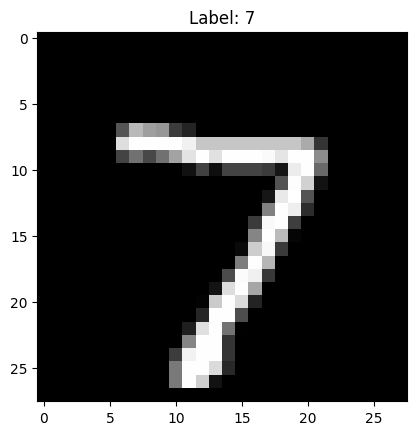

In [56]:
X = df.drop('label', axis=1).values
Y = df['label'].values

image = X[0].reshape(28,28)
plt.imshow(image, cmap='gray')
plt.title(f'Label: {Y[0]}')
plt.show()


In [57]:
class MNISTDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features) / 255.0
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

dataset = MNISTDataset(X, Y)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train size: {len(train_dataset)}, Test size: {len(test_dataset)}')

Train size: 7000, Test size: 3000


In [58]:
class MPL(nn.Module):
    def __init__(self, input_size=784, hidden_size1= 128, hidden_size2=64, num_classes=10):
        super(MPL, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MPL().to(device)

print("Device:", device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')



Device: cuda
MPL(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)
Total parameters: 109386


In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/15], Loss: 0.9329
Epoch [2/15], Loss: 0.3350
Epoch [3/15], Loss: 0.2622
Epoch [4/15], Loss: 0.2124
Epoch [5/15], Loss: 0.1774
Epoch [6/15], Loss: 0.1422
Epoch [7/15], Loss: 0.1182
Epoch [8/15], Loss: 0.1005
Epoch [9/15], Loss: 0.0830
Epoch [10/15], Loss: 0.0697
Epoch [11/15], Loss: 0.0599
Epoch [12/15], Loss: 0.0469
Epoch [13/15], Loss: 0.0371
Epoch [14/15], Loss: 0.0277
Epoch [15/15], Loss: 0.0252


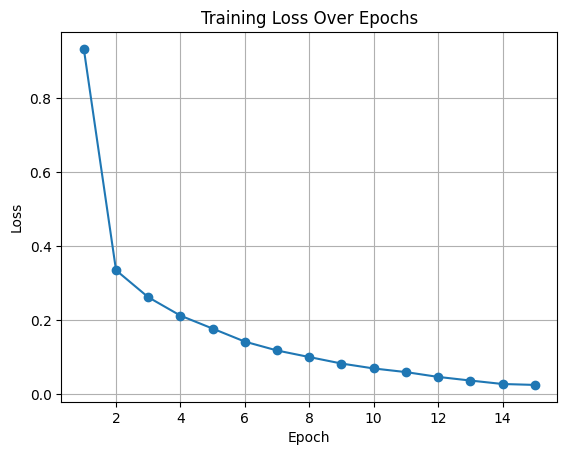

In [60]:
num_epochs = 15

model.train()
loss_history = []

for epoch in range(num_epochs):
    running_loss = 0.0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        outputs = model(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad() # Important step to clear previous gradients, otherwise left over artifacts could accumulate
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # TQDM Progress Bar (optional)???
plt.plot(range(1, num_epochs + 1), loss_history, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()




In [61]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)

        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 94.47%


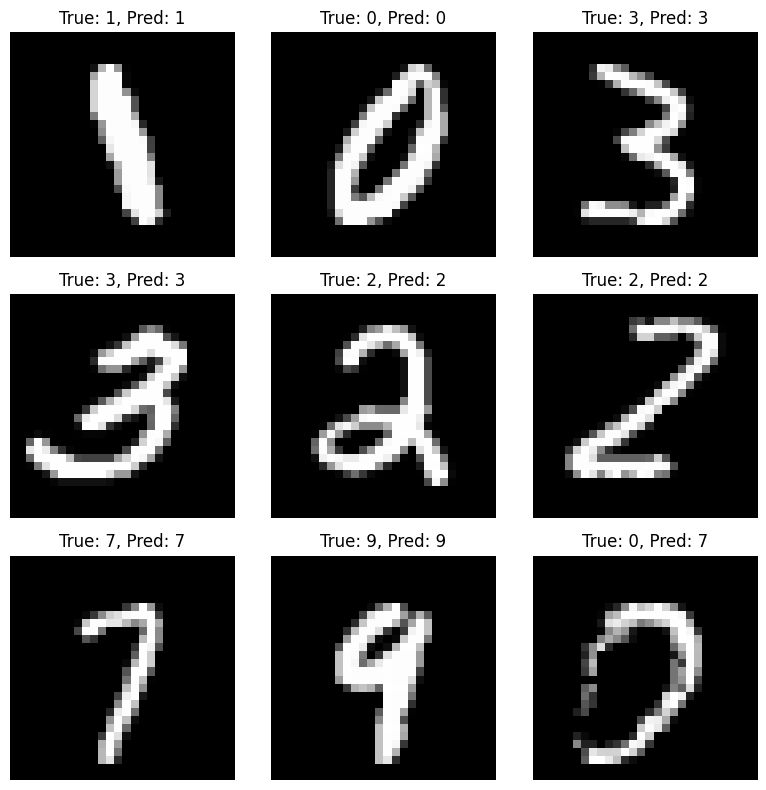

In [62]:
# Visualization of some predictions
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    if i < len(test_dataset):
        feature, label = test_dataset[i]
        feature = feature.to(device).unsqueeze(0)

        with torch.no_grad():
            output = model(feature)
            _, predicted = torch.max(output.data, 1)

        image = feature.cpu().numpy().reshape(28, 28)
        ax.imshow(image, cmap='gray')
        ax.set_title(f'True: {label}, Pred: {predicted.item()}')
        ax.axis('off')
plt.tight_layout()
plt.show()
        